In [14]:
import h5py
import pandas as pd
import numpy as np

# 加载数据
path = './Camp.h5'
data_mat = h5py.File(path, "r")

# 基因表达矩阵
X = np.array(data_mat['X'])  # 读取基因表达矩阵

# 检查并解析 'obs'
if 'obs' in data_mat:
    obs_group = data_mat['obs']
    print("Keys in 'obs':", list(obs_group.keys()))  # 列出 obs 中的键

    # 提取 Group 作为标签
    if 'Group' in obs_group:
        Y = np.array(obs_group['Group'])  # 使用 'Group' 作为标签
        print("First 10 labels in 'Group':", Y[:10])
    else:
        raise KeyError("'Group' key not found in 'obs'.")
else:
    raise KeyError("'obs' key not found in the HDF5 file. Cannot extract labels.")

# 稀疏度计算
print("Sparsity: ", np.where(X == 0)[0].shape[0] / (X.shape[0] * X.shape[1]))

# 打印基因表达矩阵和标签维度
print("基因表达矩阵维度:", X.shape)
print("标签维度:", Y.shape)

Keys in 'obs': ['Group', 'cell_id']
First 10 labels in 'Group': [0 0 0 0 0 0 0 0 0 0]
Sparsity:  0.6728394475782307
基因表达矩阵维度: (777, 16270)
标签维度: (777,)


/var/folders/3k/wtktqhhs2szgg7m8yyz29zgr0000gn/T/ipykernel_5380/4249700500.py:10: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  X = np.array(data_mat['X'])  # 读取基因表达矩阵
/var/folders/3k/wtktqhhs2szgg7m8yyz29zgr0000gn/T/ipykernel_5380/4249700500.py:19: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  Y = np.array(obs_group['Group'])  # 使用 'Group' 作为标签


In [17]:
import h5py
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
from sklearn.decomposition import PCA
from torch_geometric.utils import erdos_renyi_graph, dense_to_sparse
import train

# 加载数据
path = './Camp.h5'
data_mat = h5py.File(path, "r")

# 基因表达矩阵
X = np.array(data_mat['X'])  # 读取基因表达矩阵

# 提取 'Group' 作为标签
if 'obs' in data_mat and 'Group' in data_mat['obs']:
    Y = np.array(data_mat['obs']['Group'])  # 使用 'Group' 作为标签
    print("First 10 labels in 'Group':", Y[:10])
else:
    raise KeyError("'Group' key not found in 'obs'.")

# 稀疏度计算
print("Sparsity: ", np.where(X == 0)[0].shape[0] / (X.shape[0] * X.shape[1]))

# 筛选高变异基因
nb_genes = 3000
genes_idx, cells_idx = train.filter_data(X, highly_genes=nb_genes)
X = X[cells_idx][:, genes_idx]
Y = Y[cells_idx]
n_clusters = len(np.unique(Y))  # 计算标签数量

# PCA降维
pca_size = 50
pca = PCA(n_components=pca_size)
X_pca = pca.fit_transform(X)  # PCA降维后的基因表达矩阵

# 转换为 torch tensor
x = torch.tensor(X_pca, dtype=torch.float)
y = torch.tensor(Y, dtype=torch.long)

# 构建随机图
num_nodes = x.shape[0]
adj_matrix = torch.rand((num_nodes, num_nodes)) < 0.05  # 按概率生成邻接矩阵
adj_matrix = adj_matrix.to(torch.float)  # 转为 float 类型
edge_index, edge_attr = dense_to_sparse(adj_matrix)  # 转换为稀疏格式

# 转换为图数据对象
data = Data(x=x, edge_index=edge_index, y=y)
loader = DataLoader([data], batch_size=1)

# 打印信息
print("基因表达矩阵维度:", X.shape)
print("标签维度:", Y.shape)
print("图数据对象:", data)

/var/folders/3k/wtktqhhs2szgg7m8yyz29zgr0000gn/T/ipykernel_5380/732149545.py:15: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  X = np.array(data_mat['X'])  # 读取基因表达矩阵
/var/folders/3k/wtktqhhs2szgg7m8yyz29zgr0000gn/T/ipykernel_5380/732149545.py:19: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  Y = np.array(data_mat['obs']['Group'])  # 使用 'Group' 作为标签
/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


First 10 labels in 'Group': [0 0 0 0 0 0 0 0 0 0]
Sparsity:  0.6728394475782307
基因表达矩阵维度: (777, 3000)
标签维度: (777,)
图数据对象: Data(x=[777, 50], edge_index=[2, 30007], y=[777])


/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [18]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)  # 输出节点嵌入
        return x

In [19]:
# 初始化模型和优化器
model = GCNEncoder(in_channels=pca_size, hidden_channels=200, out_channels=50).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_model(model, loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            z = model(batch.x, batch.edge_index)  # 前向传播：节点嵌入
            loss = F.mse_loss(z, batch.x)  # 重建损失（自编码器）
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# 训练模型
epochs = 10
train_model(model, loader, optimizer, epochs)

Epoch 1/10, Loss: 113.2034
Epoch 2/10, Loss: 113.1246
Epoch 3/10, Loss: 113.0616
Epoch 4/10, Loss: 113.0121
Epoch 5/10, Loss: 112.9734
Epoch 6/10, Loss: 112.9433
Epoch 7/10, Loss: 112.9193
Epoch 8/10, Loss: 112.8996
Epoch 9/10, Loss: 112.8826
Epoch 10/10, Loss: 112.8671


/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


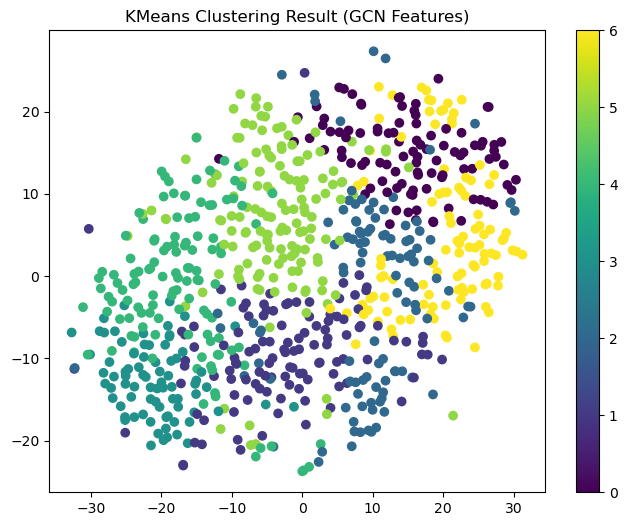

In [20]:
# 获取节点嵌入
model.eval()
with torch.no_grad():
    z = model(data.x, data.edge_index).cpu().numpy()  # 输出节点嵌入

# 使用 KMeans 聚类
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_pred = kmeans.fit_predict(z)

# t-SNE 可视化
X_embedded = TSNE(n_components=2).fit_transform(z)
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=kmeans_pred, cmap='viridis')
plt.title("KMeans Clustering Result (GCN Features)")
plt.colorbar()
plt.show()